In [1]:
import torch
import torch.nn as nn
import torch.optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from DropBackVGGS import DropBackVGGS
import matplotlib.pyplot as plt
import numpy as np
import pickle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [18]:
def train(epochs: int, model: DropBackVGGS, train_loader: DataLoader, val_loader: DataLoader, optim: torch.optim.SGD, criterion, device, in_size: int, freeze_epoch: int):
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - train"):
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            # images = images.view(-1, in_size)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        train_acc = correct / total
        train_loss /= len(train_loader)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - val"):
                images, labels = images.to(device), labels.to(device)
                # images = images.view(-1, in_size)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        val_acc = correct / total
        val_loss /= len(val_loader)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.3%}")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.3%}")

        if epoch == freeze_epoch - 1:
            model.freeze_params()
        if epoch >= freeze_epoch - 1:
            model.reset_frozen(device)
    return train_accs, val_accs, model

In [12]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = datasets.CIFAR10(root="cifar", download=False, train=True, transform=transform)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [13]:
in_channels = 3
output_size = 10

In [14]:
criterion = nn.CrossEntropyLoss()

def run_test(epochs, prune, freeze):
    # seed = np.random.randint(0, 10000)
    seed = 0
    model = DropBackVGGS(in_channels, output_size, prune, seed).to(device)
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    return train(epochs, model, train_loader, val_loader, optim, criterion, device, in_channels, freeze)

Epoch 1 - val: 100%|██████████| 625/625 [00:02<00:00, 211.26it/s]


Epoch 1:
Train Loss: 1.5610, Accuracy: 0.4408
Val Loss: 1.2379, Accuracy: 0.5619


Epoch 2 - val: 100%|██████████| 625/625 [00:02<00:00, 225.19it/s]


Epoch 2:
Train Loss: 1.1500, Accuracy: 0.5949
Val Loss: 1.1388, Accuracy: 0.5904


Epoch 3 - val: 100%|██████████| 625/625 [00:03<00:00, 191.71it/s]


Epoch 3:
Train Loss: 0.9619, Accuracy: 0.6632
Val Loss: 0.9923, Accuracy: 0.6530


Epoch 4 - val: 100%|██████████| 625/625 [00:02<00:00, 233.44it/s]


Epoch 4:
Train Loss: 0.8233, Accuracy: 0.7096
Val Loss: 0.9841, Accuracy: 0.6634


Epoch 5 - val: 100%|██████████| 625/625 [00:02<00:00, 248.71it/s]


Epoch 5:
Train Loss: 0.7000, Accuracy: 0.7520
Val Loss: 0.9389, Accuracy: 0.6908


Epoch 6 - val: 100%|██████████| 625/625 [00:02<00:00, 209.50it/s]


Epoch 6:
Train Loss: 0.5946, Accuracy: 0.7922
Val Loss: 0.9028, Accuracy: 0.7034


Epoch 7 - val: 100%|██████████| 625/625 [00:03<00:00, 201.55it/s]


Epoch 7:
Train Loss: 0.4914, Accuracy: 0.8267
Val Loss: 0.9833, Accuracy: 0.7011


Epoch 8 - val: 100%|██████████| 625/625 [00:02<00:00, 249.66it/s]


Epoch 8:
Train Loss: 0.4048, Accuracy: 0.8569
Val Loss: 1.1330, Accuracy: 0.6878


Epoch 9 - val: 100%|██████████| 625/625 [00:03<00:00, 178.83it/s]


Epoch 9:
Train Loss: 0.3208, Accuracy: 0.8853
Val Loss: 1.1030, Accuracy: 0.7106


Epoch 10 - val: 100%|██████████| 625/625 [00:02<00:00, 248.81it/s]


Epoch 10:
Train Loss: 0.2480, Accuracy: 0.9134
Val Loss: 1.3283, Accuracy: 0.6900


Epoch 11 - val: 100%|██████████| 625/625 [00:03<00:00, 204.20it/s]


Epoch 11:
Train Loss: 0.2135, Accuracy: 0.9258
Val Loss: 1.3180, Accuracy: 0.7055


Epoch 12 - val: 100%|██████████| 625/625 [00:03<00:00, 201.86it/s]


Epoch 12:
Train Loss: 0.1819, Accuracy: 0.9358
Val Loss: 1.5529, Accuracy: 0.6872


Epoch 13 - val: 100%|██████████| 625/625 [00:02<00:00, 239.28it/s]


Epoch 13:
Train Loss: 0.1648, Accuracy: 0.9438
Val Loss: 1.5235, Accuracy: 0.7139


Epoch 14 - val: 100%|██████████| 625/625 [00:02<00:00, 246.08it/s]


Epoch 14:
Train Loss: 0.1563, Accuracy: 0.9476
Val Loss: 1.5653, Accuracy: 0.7060


Epoch 15 - val: 100%|██████████| 625/625 [00:03<00:00, 207.32it/s]


Epoch 15:
Train Loss: 0.1354, Accuracy: 0.9538
Val Loss: 1.7550, Accuracy: 0.7027


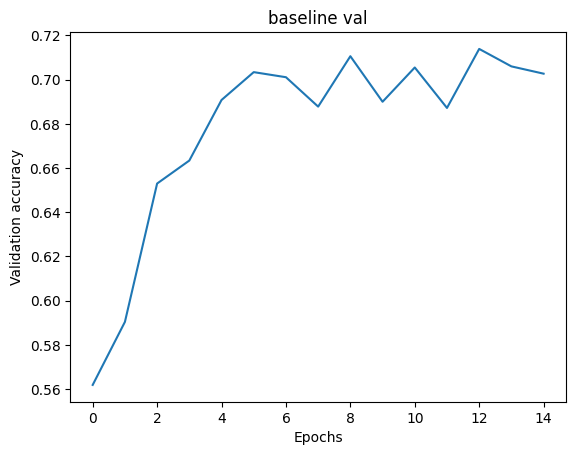

In [7]:
seed = 0
baseline_model = DropBackVGGS(in_channels, output_size, pruning_threshold=0, seed=0).to(device)
optim = torch.optim.SGD(baseline_model.parameters(), lr=0.03)

baseline = train(5, baseline_model, train_loader, val_loader, optim, criterion, device, in_channels, freeze_epoch=1000)

plt.plot(baseline[1], label=f"baseline")
plt.title("baseline val")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()

In [19]:
seed = 0
test_model = DropBackVGGS(in_channels, output_size, pruning_threshold=0.5, seed=None).to(device)
optim = torch.optim.SGD(test_model.parameters(), lr=0.03)

test = train(10, test_model, train_loader, val_loader, optim, criterion, device, in_channels, freeze_epoch=1000)

plt.plot(test[1], label=f"test")
plt.title("test val")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()

Epoch 1 - val: 100%|██████████| 625/625 [00:04<00:00, 156.11it/s]


Epoch 1:
Train Loss: 2.3705, Accuracy: 9.992%
Val Loss: 2.3050, Accuracy: 9.800%


Epoch 2 - val: 100%|██████████| 625/625 [00:04<00:00, 150.51it/s]


Epoch 2:
Train Loss: 2.3069, Accuracy: 9.820%
Val Loss: 2.3097, Accuracy: 9.660%


Epoch 3 - val: 100%|██████████| 625/625 [00:04<00:00, 155.56it/s]


Epoch 3:
Train Loss: 2.3071, Accuracy: 9.775%
Val Loss: 2.3049, Accuracy: 10.050%


Epoch 4 - train:  16%|█▌        | 402/2500 [00:03<00:20, 103.13it/s]


KeyboardInterrupt: 

In [ ]:
with open('baseline_cifar.pkl', 'wb') as f:
    pickle.dump(baseline, f)

In [ ]:
results_dict = {}

In [111]:
epochs = 50
pruning =  [.1, .1, .1]
freezing = [ 2,  8, 10]

i = 0
for prune, freeze in zip(pruning, freezing):
    print(f"<=== TEST {i+1} OF {len(pruning)} ===>")
    result = run_test(epochs, prune, freeze)
    results_dict[(prune, freeze)] = result
    i += 1

pruning =  [.25, .25, .25]
freezing = [  2,   8,  10]
i = 0
for prune, freeze in zip(pruning, freezing):
    print(f"<=== TEST {i+1} OF {len(pruning)} ===>")
    result = run_test(epochs, prune, freeze)
    results_dict[(prune, freeze)] = result
    i += 1

pruning =  [.9, .9, .9]
freezing = [ 2,  8, 10]
i = 0
for prune, freeze in zip(pruning, freezing):
    print(f"<=== TEST {i+1} OF {len(pruning)} ===>")
    result = run_test(epochs, prune, freeze)
    results_dict[(prune, freeze)] = result
    i += 1


<=== TEST 1 OF 3 ===>


Epoch 1 - train:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 270.15it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:02<00:00, 293.57it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561
======== Pruned weights: 7951 out of 79510 ========


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 267.27it/s]


Epoch 3:
Train Loss: 0.1397, Accuracy: 0.9604
Val Loss: 0.1451, Accuracy: 0.9573


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 346.30it/s]


Epoch 4:
Train Loss: 0.1136, Accuracy: 0.9685
Val Loss: 0.1273, Accuracy: 0.9624


Epoch 5 - val: 100%|██████████| 750/750 [00:02<00:00, 316.54it/s]


Epoch 5:
Train Loss: 0.0965, Accuracy: 0.9723
Val Loss: 0.1140, Accuracy: 0.9657


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 281.32it/s]


Epoch 6:
Train Loss: 0.0838, Accuracy: 0.9760
Val Loss: 0.1115, Accuracy: 0.9666


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 255.46it/s]


Epoch 7:
Train Loss: 0.0737, Accuracy: 0.9789
Val Loss: 0.1110, Accuracy: 0.9666


Epoch 8 - val: 100%|██████████| 750/750 [00:02<00:00, 332.84it/s]


Epoch 8:
Train Loss: 0.0658, Accuracy: 0.9818
Val Loss: 0.1072, Accuracy: 0.9683


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 266.05it/s]


Epoch 9:
Train Loss: 0.0589, Accuracy: 0.9842
Val Loss: 0.1006, Accuracy: 0.9697


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 369.42it/s]


Epoch 10:
Train Loss: 0.0529, Accuracy: 0.9855
Val Loss: 0.0988, Accuracy: 0.9706


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 369.65it/s]


Epoch 11:
Train Loss: 0.0483, Accuracy: 0.9871
Val Loss: 0.0951, Accuracy: 0.9722


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 360.76it/s]


Epoch 12:
Train Loss: 0.0434, Accuracy: 0.9885
Val Loss: 0.1013, Accuracy: 0.9683


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 274.68it/s]


Epoch 13:
Train Loss: 0.0401, Accuracy: 0.9894
Val Loss: 0.0947, Accuracy: 0.9714


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 303.08it/s]


Epoch 14:
Train Loss: 0.0364, Accuracy: 0.9909
Val Loss: 0.0964, Accuracy: 0.9713


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 372.73it/s]


Epoch 15:
Train Loss: 0.0331, Accuracy: 0.9918
Val Loss: 0.0957, Accuracy: 0.9713


Epoch 16 - val: 100%|██████████| 750/750 [00:01<00:00, 410.47it/s]


Epoch 16:
Train Loss: 0.0303, Accuracy: 0.9931
Val Loss: 0.0941, Accuracy: 0.9728


Epoch 17 - val: 100%|██████████| 750/750 [00:01<00:00, 382.73it/s]


Epoch 17:
Train Loss: 0.0280, Accuracy: 0.9936
Val Loss: 0.0952, Accuracy: 0.9718


Epoch 18 - val: 100%|██████████| 750/750 [00:01<00:00, 427.58it/s]


Epoch 18:
Train Loss: 0.0257, Accuracy: 0.9943
Val Loss: 0.0936, Accuracy: 0.9723


Epoch 19 - val: 100%|██████████| 750/750 [00:01<00:00, 377.06it/s]


Epoch 19:
Train Loss: 0.0237, Accuracy: 0.9950
Val Loss: 0.0951, Accuracy: 0.9728


Epoch 20 - val: 100%|██████████| 750/750 [00:01<00:00, 394.99it/s]


Epoch 20:
Train Loss: 0.0217, Accuracy: 0.9958
Val Loss: 0.0950, Accuracy: 0.9732


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 358.93it/s]


Epoch 21:
Train Loss: 0.0198, Accuracy: 0.9963
Val Loss: 0.0960, Accuracy: 0.9725


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 338.75it/s]


Epoch 22:
Train Loss: 0.0183, Accuracy: 0.9969
Val Loss: 0.0960, Accuracy: 0.9722


Epoch 23 - val: 100%|██████████| 750/750 [00:01<00:00, 381.19it/s]


Epoch 23:
Train Loss: 0.0169, Accuracy: 0.9974
Val Loss: 0.0983, Accuracy: 0.9721


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 370.90it/s]


Epoch 24:
Train Loss: 0.0157, Accuracy: 0.9976
Val Loss: 0.0960, Accuracy: 0.9718


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 252.59it/s]


Epoch 25:
Train Loss: 0.0147, Accuracy: 0.9982
Val Loss: 0.0966, Accuracy: 0.9747


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 328.86it/s]


Epoch 26:
Train Loss: 0.0136, Accuracy: 0.9983
Val Loss: 0.0944, Accuracy: 0.9743


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 319.32it/s]


Epoch 27:
Train Loss: 0.0125, Accuracy: 0.9988
Val Loss: 0.0996, Accuracy: 0.9727


Epoch 28 - val: 100%|██████████| 750/750 [00:01<00:00, 382.85it/s]


Epoch 28:
Train Loss: 0.0117, Accuracy: 0.9987
Val Loss: 0.0970, Accuracy: 0.9739


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 349.04it/s]


Epoch 29:
Train Loss: 0.0109, Accuracy: 0.9991
Val Loss: 0.0957, Accuracy: 0.9740


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 349.93it/s]


Epoch 30:
Train Loss: 0.0102, Accuracy: 0.9991
Val Loss: 0.0959, Accuracy: 0.9728


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 336.31it/s]


Epoch 31:
Train Loss: 0.0095, Accuracy: 0.9992
Val Loss: 0.0973, Accuracy: 0.9733


Epoch 32 - val: 100%|██████████| 750/750 [00:01<00:00, 397.12it/s]


Epoch 32:
Train Loss: 0.0090, Accuracy: 0.9993
Val Loss: 0.0981, Accuracy: 0.9733


Epoch 33 - val: 100%|██████████| 750/750 [00:01<00:00, 379.10it/s]


Epoch 33:
Train Loss: 0.0084, Accuracy: 0.9995
Val Loss: 0.1002, Accuracy: 0.9727


Epoch 34 - val: 100%|██████████| 750/750 [00:01<00:00, 386.18it/s]


Epoch 34:
Train Loss: 0.0080, Accuracy: 0.9995
Val Loss: 0.0986, Accuracy: 0.9738


Epoch 35 - val: 100%|██████████| 750/750 [00:01<00:00, 376.70it/s]


Epoch 35:
Train Loss: 0.0075, Accuracy: 0.9995
Val Loss: 0.0987, Accuracy: 0.9736


Epoch 36 - val: 100%|██████████| 750/750 [00:02<00:00, 363.48it/s]


Epoch 36:
Train Loss: 0.0071, Accuracy: 0.9997
Val Loss: 0.0996, Accuracy: 0.9734


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 296.02it/s]


Epoch 37:
Train Loss: 0.0067, Accuracy: 0.9997
Val Loss: 0.0998, Accuracy: 0.9735


Epoch 38 - val: 100%|██████████| 750/750 [00:03<00:00, 243.84it/s]


Epoch 38:
Train Loss: 0.0063, Accuracy: 0.9998
Val Loss: 0.1007, Accuracy: 0.9739


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 278.47it/s]


Epoch 39:
Train Loss: 0.0060, Accuracy: 0.9998
Val Loss: 0.1007, Accuracy: 0.9736


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 370.91it/s]


Epoch 40:
Train Loss: 0.0057, Accuracy: 0.9998
Val Loss: 0.1008, Accuracy: 0.9737


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 346.52it/s]


Epoch 41:
Train Loss: 0.0054, Accuracy: 0.9999
Val Loss: 0.1009, Accuracy: 0.9738


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 299.02it/s]


Epoch 42:
Train Loss: 0.0052, Accuracy: 0.9999
Val Loss: 0.1012, Accuracy: 0.9735


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 303.42it/s]


Epoch 43:
Train Loss: 0.0050, Accuracy: 0.9999
Val Loss: 0.1025, Accuracy: 0.9735


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 278.68it/s]


Epoch 44:
Train Loss: 0.0047, Accuracy: 0.9999
Val Loss: 0.1025, Accuracy: 0.9744


Epoch 45 - val: 100%|██████████| 750/750 [00:03<00:00, 246.07it/s]


Epoch 45:
Train Loss: 0.0045, Accuracy: 0.9999
Val Loss: 0.1033, Accuracy: 0.9736


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 299.88it/s]


Epoch 46:
Train Loss: 0.0043, Accuracy: 1.0000
Val Loss: 0.1039, Accuracy: 0.9732


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 321.92it/s]


Epoch 47:
Train Loss: 0.0042, Accuracy: 0.9999
Val Loss: 0.1026, Accuracy: 0.9742


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 262.35it/s]


Epoch 48:
Train Loss: 0.0040, Accuracy: 1.0000
Val Loss: 0.1037, Accuracy: 0.9742


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 336.94it/s]


Epoch 49:
Train Loss: 0.0039, Accuracy: 1.0000
Val Loss: 0.1047, Accuracy: 0.9736


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 346.42it/s]


Epoch 50:
Train Loss: 0.0037, Accuracy: 1.0000
Val Loss: 0.1043, Accuracy: 0.9748
<=== TEST 2 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 346.79it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:02<00:00, 354.01it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 322.46it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 342.61it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:02<00:00, 338.82it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 333.07it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 311.91it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:02<00:00, 305.91it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689
======== Pruned weights: 7951 out of 79510 ========


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 337.86it/s]


Epoch 9:
Train Loss: 0.0662, Accuracy: 0.9820
Val Loss: 0.1018, Accuracy: 0.9693


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 336.50it/s]


Epoch 10:
Train Loss: 0.0577, Accuracy: 0.9839
Val Loss: 0.0994, Accuracy: 0.9712


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 332.16it/s]


Epoch 11:
Train Loss: 0.0517, Accuracy: 0.9858
Val Loss: 0.0952, Accuracy: 0.9718


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 336.48it/s]


Epoch 12:
Train Loss: 0.0459, Accuracy: 0.9880
Val Loss: 0.1001, Accuracy: 0.9687


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 355.37it/s]


Epoch 13:
Train Loss: 0.0423, Accuracy: 0.9885
Val Loss: 0.0934, Accuracy: 0.9732


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 328.54it/s]


Epoch 14:
Train Loss: 0.0379, Accuracy: 0.9907
Val Loss: 0.0956, Accuracy: 0.9722


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 355.37it/s]


Epoch 15:
Train Loss: 0.0347, Accuracy: 0.9912
Val Loss: 0.0935, Accuracy: 0.9728


Epoch 16 - val: 100%|██████████| 750/750 [00:02<00:00, 371.81it/s]


Epoch 16:
Train Loss: 0.0316, Accuracy: 0.9927
Val Loss: 0.0916, Accuracy: 0.9721


Epoch 17 - val: 100%|██████████| 750/750 [00:03<00:00, 230.19it/s]


Epoch 17:
Train Loss: 0.0290, Accuracy: 0.9936
Val Loss: 0.0933, Accuracy: 0.9724


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 343.89it/s]


Epoch 18:
Train Loss: 0.0267, Accuracy: 0.9941
Val Loss: 0.0919, Accuracy: 0.9728


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 341.74it/s]


Epoch 19:
Train Loss: 0.0245, Accuracy: 0.9948
Val Loss: 0.0927, Accuracy: 0.9720


Epoch 20 - val: 100%|██████████| 750/750 [00:02<00:00, 336.06it/s]


Epoch 20:
Train Loss: 0.0224, Accuracy: 0.9956
Val Loss: 0.0936, Accuracy: 0.9726


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 348.37it/s]


Epoch 21:
Train Loss: 0.0206, Accuracy: 0.9961
Val Loss: 0.0927, Accuracy: 0.9730


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 325.23it/s]


Epoch 22:
Train Loss: 0.0190, Accuracy: 0.9967
Val Loss: 0.0933, Accuracy: 0.9732


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 309.98it/s]


Epoch 23:
Train Loss: 0.0177, Accuracy: 0.9971
Val Loss: 0.0952, Accuracy: 0.9731


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 335.35it/s]


Epoch 24:
Train Loss: 0.0162, Accuracy: 0.9977
Val Loss: 0.0932, Accuracy: 0.9726


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 342.61it/s]


Epoch 25:
Train Loss: 0.0152, Accuracy: 0.9981
Val Loss: 0.0941, Accuracy: 0.9737


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 334.59it/s]


Epoch 26:
Train Loss: 0.0142, Accuracy: 0.9980
Val Loss: 0.0913, Accuracy: 0.9738


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 342.08it/s]


Epoch 27:
Train Loss: 0.0131, Accuracy: 0.9986
Val Loss: 0.0955, Accuracy: 0.9723


Epoch 28 - val: 100%|██████████| 750/750 [00:02<00:00, 325.32it/s]


Epoch 28:
Train Loss: 0.0122, Accuracy: 0.9987
Val Loss: 0.0933, Accuracy: 0.9747


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 334.71it/s]


Epoch 29:
Train Loss: 0.0114, Accuracy: 0.9989
Val Loss: 0.0923, Accuracy: 0.9739


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 333.64it/s]


Epoch 30:
Train Loss: 0.0106, Accuracy: 0.9989
Val Loss: 0.0941, Accuracy: 0.9729


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 311.09it/s]


Epoch 31:
Train Loss: 0.0099, Accuracy: 0.9993
Val Loss: 0.0932, Accuracy: 0.9742


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 341.38it/s]


Epoch 32:
Train Loss: 0.0094, Accuracy: 0.9992
Val Loss: 0.0947, Accuracy: 0.9729


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 343.16it/s]


Epoch 33:
Train Loss: 0.0088, Accuracy: 0.9994
Val Loss: 0.0954, Accuracy: 0.9730


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 302.24it/s]


Epoch 34:
Train Loss: 0.0083, Accuracy: 0.9994
Val Loss: 0.0945, Accuracy: 0.9738


Epoch 35 - val: 100%|██████████| 750/750 [00:02<00:00, 355.44it/s]


Epoch 35:
Train Loss: 0.0078, Accuracy: 0.9995
Val Loss: 0.0945, Accuracy: 0.9742


Epoch 36 - val: 100%|██████████| 750/750 [00:02<00:00, 296.10it/s]


Epoch 36:
Train Loss: 0.0074, Accuracy: 0.9997
Val Loss: 0.0952, Accuracy: 0.9746


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 296.09it/s]


Epoch 37:
Train Loss: 0.0069, Accuracy: 0.9995
Val Loss: 0.0956, Accuracy: 0.9742


Epoch 38 - val: 100%|██████████| 750/750 [00:03<00:00, 239.85it/s]


Epoch 38:
Train Loss: 0.0066, Accuracy: 0.9997
Val Loss: 0.0967, Accuracy: 0.9738


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 276.84it/s]


Epoch 39:
Train Loss: 0.0063, Accuracy: 0.9998
Val Loss: 0.0956, Accuracy: 0.9738


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 259.17it/s]


Epoch 40:
Train Loss: 0.0060, Accuracy: 0.9998
Val Loss: 0.0961, Accuracy: 0.9746


Epoch 41 - val: 100%|██████████| 750/750 [00:03<00:00, 241.45it/s]


Epoch 41:
Train Loss: 0.0056, Accuracy: 0.9998
Val Loss: 0.0961, Accuracy: 0.9740


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 276.29it/s]


Epoch 42:
Train Loss: 0.0054, Accuracy: 0.9998
Val Loss: 0.0957, Accuracy: 0.9751


Epoch 43 - val: 100%|██████████| 750/750 [00:03<00:00, 247.00it/s]


Epoch 43:
Train Loss: 0.0052, Accuracy: 0.9998
Val Loss: 0.0973, Accuracy: 0.9747


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 311.69it/s]


Epoch 44:
Train Loss: 0.0050, Accuracy: 0.9998
Val Loss: 0.0971, Accuracy: 0.9743


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 259.93it/s]


Epoch 45:
Train Loss: 0.0048, Accuracy: 0.9999
Val Loss: 0.0981, Accuracy: 0.9750


Epoch 46 - val: 100%|██████████| 750/750 [00:04<00:00, 177.99it/s]


Epoch 46:
Train Loss: 0.0046, Accuracy: 0.9999
Val Loss: 0.0980, Accuracy: 0.9748


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 363.67it/s]


Epoch 47:
Train Loss: 0.0044, Accuracy: 0.9999
Val Loss: 0.0972, Accuracy: 0.9742


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 259.91it/s]


Epoch 48:
Train Loss: 0.0042, Accuracy: 0.9999
Val Loss: 0.0990, Accuracy: 0.9738


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 365.89it/s]


Epoch 49:
Train Loss: 0.0041, Accuracy: 0.9999
Val Loss: 0.0994, Accuracy: 0.9742


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 266.98it/s]


Epoch 50:
Train Loss: 0.0039, Accuracy: 0.9999
Val Loss: 0.0987, Accuracy: 0.9747
<=== TEST 3 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:03<00:00, 248.17it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:03<00:00, 228.40it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 298.54it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 308.90it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:02<00:00, 310.24it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 257.81it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 276.85it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:02<00:00, 274.77it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689


Epoch 9 - val: 100%|██████████| 750/750 [00:03<00:00, 245.85it/s]


Epoch 9:
Train Loss: 0.0532, Accuracy: 0.9858
Val Loss: 0.0973, Accuracy: 0.9708


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 306.44it/s]


Epoch 10:
Train Loss: 0.0475, Accuracy: 0.9871
Val Loss: 0.0952, Accuracy: 0.9725
======== Pruned weights: 7951 out of 79510 ========


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 308.53it/s]


Epoch 11:
Train Loss: 0.0570, Accuracy: 0.9846
Val Loss: 0.0985, Accuracy: 0.9712


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 299.74it/s]


Epoch 12:
Train Loss: 0.0494, Accuracy: 0.9866
Val Loss: 0.1012, Accuracy: 0.9692


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 277.44it/s]


Epoch 13:
Train Loss: 0.0450, Accuracy: 0.9878
Val Loss: 0.0951, Accuracy: 0.9711


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 273.30it/s]


Epoch 14:
Train Loss: 0.0403, Accuracy: 0.9898
Val Loss: 0.0968, Accuracy: 0.9699


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 288.94it/s]


Epoch 15:
Train Loss: 0.0367, Accuracy: 0.9907
Val Loss: 0.0955, Accuracy: 0.9712


Epoch 16 - val: 100%|██████████| 750/750 [00:02<00:00, 310.73it/s]


Epoch 16:
Train Loss: 0.0334, Accuracy: 0.9919
Val Loss: 0.0935, Accuracy: 0.9719


Epoch 17 - val: 100%|██████████| 750/750 [00:02<00:00, 294.22it/s]


Epoch 17:
Train Loss: 0.0309, Accuracy: 0.9925
Val Loss: 0.0945, Accuracy: 0.9718


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 290.49it/s]


Epoch 18:
Train Loss: 0.0283, Accuracy: 0.9936
Val Loss: 0.0931, Accuracy: 0.9732


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 313.20it/s]


Epoch 19:
Train Loss: 0.0260, Accuracy: 0.9944
Val Loss: 0.0949, Accuracy: 0.9721


Epoch 20 - val: 100%|██████████| 750/750 [00:04<00:00, 171.88it/s]


Epoch 20:
Train Loss: 0.0238, Accuracy: 0.9951
Val Loss: 0.0953, Accuracy: 0.9724


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 322.76it/s]


Epoch 21:
Train Loss: 0.0219, Accuracy: 0.9955
Val Loss: 0.0934, Accuracy: 0.9721


Epoch 22 - val: 100%|██████████| 750/750 [00:03<00:00, 247.28it/s]


Epoch 22:
Train Loss: 0.0200, Accuracy: 0.9963
Val Loss: 0.0966, Accuracy: 0.9723


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 260.18it/s]


Epoch 23:
Train Loss: 0.0188, Accuracy: 0.9965
Val Loss: 0.0955, Accuracy: 0.9716


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 307.12it/s]


Epoch 24:
Train Loss: 0.0173, Accuracy: 0.9970
Val Loss: 0.0942, Accuracy: 0.9733


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 281.18it/s]


Epoch 25:
Train Loss: 0.0161, Accuracy: 0.9975
Val Loss: 0.0940, Accuracy: 0.9728


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 316.43it/s]


Epoch 26:
Train Loss: 0.0149, Accuracy: 0.9978
Val Loss: 0.0926, Accuracy: 0.9733


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 300.80it/s]


Epoch 27:
Train Loss: 0.0138, Accuracy: 0.9984
Val Loss: 0.0992, Accuracy: 0.9711


Epoch 28 - val: 100%|██████████| 750/750 [00:03<00:00, 230.34it/s]


Epoch 28:
Train Loss: 0.0128, Accuracy: 0.9986
Val Loss: 0.0952, Accuracy: 0.9725


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 314.03it/s]


Epoch 29:
Train Loss: 0.0121, Accuracy: 0.9988
Val Loss: 0.0944, Accuracy: 0.9732


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 338.69it/s]


Epoch 30:
Train Loss: 0.0112, Accuracy: 0.9989
Val Loss: 0.0950, Accuracy: 0.9729


Epoch 31 - val: 100%|██████████| 750/750 [00:03<00:00, 235.93it/s]


Epoch 31:
Train Loss: 0.0106, Accuracy: 0.9990
Val Loss: 0.0955, Accuracy: 0.9737


Epoch 32 - val: 100%|██████████| 750/750 [00:03<00:00, 231.42it/s]


Epoch 32:
Train Loss: 0.0099, Accuracy: 0.9992
Val Loss: 0.0961, Accuracy: 0.9727


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 290.34it/s]


Epoch 33:
Train Loss: 0.0093, Accuracy: 0.9993
Val Loss: 0.0982, Accuracy: 0.9722


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 312.21it/s]


Epoch 34:
Train Loss: 0.0089, Accuracy: 0.9994
Val Loss: 0.0968, Accuracy: 0.9728


Epoch 35 - val: 100%|██████████| 750/750 [00:01<00:00, 384.99it/s]


Epoch 35:
Train Loss: 0.0083, Accuracy: 0.9995
Val Loss: 0.0964, Accuracy: 0.9724


Epoch 36 - val: 100%|██████████| 750/750 [00:01<00:00, 376.53it/s]


Epoch 36:
Train Loss: 0.0078, Accuracy: 0.9996
Val Loss: 0.0968, Accuracy: 0.9731


Epoch 37 - val: 100%|██████████| 750/750 [00:01<00:00, 392.02it/s]


Epoch 37:
Train Loss: 0.0074, Accuracy: 0.9996
Val Loss: 0.0985, Accuracy: 0.9728


Epoch 38 - val: 100%|██████████| 750/750 [00:02<00:00, 317.06it/s]


Epoch 38:
Train Loss: 0.0070, Accuracy: 0.9996
Val Loss: 0.0983, Accuracy: 0.9732


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 308.81it/s]


Epoch 39:
Train Loss: 0.0067, Accuracy: 0.9998
Val Loss: 0.0974, Accuracy: 0.9731


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 276.94it/s]


Epoch 40:
Train Loss: 0.0063, Accuracy: 0.9997
Val Loss: 0.0980, Accuracy: 0.9737


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 271.20it/s]


Epoch 41:
Train Loss: 0.0060, Accuracy: 0.9998
Val Loss: 0.0982, Accuracy: 0.9729


Epoch 42 - val: 100%|██████████| 750/750 [00:01<00:00, 383.90it/s]


Epoch 42:
Train Loss: 0.0057, Accuracy: 0.9998
Val Loss: 0.0983, Accuracy: 0.9734


Epoch 43 - val: 100%|██████████| 750/750 [00:01<00:00, 385.61it/s]


Epoch 43:
Train Loss: 0.0055, Accuracy: 0.9998
Val Loss: 0.0998, Accuracy: 0.9728


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 277.05it/s]


Epoch 44:
Train Loss: 0.0052, Accuracy: 0.9998
Val Loss: 0.0994, Accuracy: 0.9732


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 299.01it/s]


Epoch 45:
Train Loss: 0.0050, Accuracy: 0.9998
Val Loss: 0.1006, Accuracy: 0.9728


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 268.95it/s]


Epoch 46:
Train Loss: 0.0048, Accuracy: 0.9999
Val Loss: 0.1009, Accuracy: 0.9732


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 341.50it/s]


Epoch 47:
Train Loss: 0.0046, Accuracy: 0.9999
Val Loss: 0.0999, Accuracy: 0.9731


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 297.87it/s]


Epoch 48:
Train Loss: 0.0044, Accuracy: 0.9999
Val Loss: 0.1011, Accuracy: 0.9725


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 350.37it/s]


Epoch 49:
Train Loss: 0.0042, Accuracy: 0.9999
Val Loss: 0.1017, Accuracy: 0.9729


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 329.86it/s]


Epoch 50:
Train Loss: 0.0041, Accuracy: 1.0000
Val Loss: 0.1016, Accuracy: 0.9725
<=== TEST 1 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 349.50it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:03<00:00, 245.97it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561
======== Pruned weights: 19877 out of 79510 ========


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 323.86it/s]


Epoch 3:
Train Loss: 0.1565, Accuracy: 0.9561
Val Loss: 0.1522, Accuracy: 0.9564


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 331.08it/s]


Epoch 4:
Train Loss: 0.1284, Accuracy: 0.9644
Val Loss: 0.1349, Accuracy: 0.9597


Epoch 5 - val: 100%|██████████| 750/750 [00:01<00:00, 376.14it/s]


Epoch 5:
Train Loss: 0.1102, Accuracy: 0.9684
Val Loss: 0.1210, Accuracy: 0.9633


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 349.52it/s]


Epoch 6:
Train Loss: 0.0969, Accuracy: 0.9724
Val Loss: 0.1164, Accuracy: 0.9649


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 336.76it/s]


Epoch 7:
Train Loss: 0.0863, Accuracy: 0.9752
Val Loss: 0.1164, Accuracy: 0.9659


Epoch 8 - val: 100%|██████████| 750/750 [00:02<00:00, 307.15it/s]


Epoch 8:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1092, Accuracy: 0.9679


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 281.32it/s]


Epoch 9:
Train Loss: 0.0705, Accuracy: 0.9805
Val Loss: 0.1036, Accuracy: 0.9687


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 371.25it/s]


Epoch 10:
Train Loss: 0.0640, Accuracy: 0.9820
Val Loss: 0.1030, Accuracy: 0.9692


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 338.10it/s]


Epoch 11:
Train Loss: 0.0591, Accuracy: 0.9841
Val Loss: 0.0973, Accuracy: 0.9720


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 320.26it/s]


Epoch 12:
Train Loss: 0.0539, Accuracy: 0.9857
Val Loss: 0.1017, Accuracy: 0.9692


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 321.74it/s]


Epoch 13:
Train Loss: 0.0501, Accuracy: 0.9866
Val Loss: 0.0981, Accuracy: 0.9712


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 335.48it/s]


Epoch 14:
Train Loss: 0.0461, Accuracy: 0.9877
Val Loss: 0.0986, Accuracy: 0.9693


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 339.71it/s]


Epoch 15:
Train Loss: 0.0424, Accuracy: 0.9892
Val Loss: 0.0975, Accuracy: 0.9705


Epoch 16 - val: 100%|██████████| 750/750 [00:02<00:00, 350.10it/s]


Epoch 16:
Train Loss: 0.0394, Accuracy: 0.9902
Val Loss: 0.0964, Accuracy: 0.9714


Epoch 17 - val: 100%|██████████| 750/750 [00:02<00:00, 338.86it/s]


Epoch 17:
Train Loss: 0.0369, Accuracy: 0.9908
Val Loss: 0.0950, Accuracy: 0.9716


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 334.32it/s]


Epoch 18:
Train Loss: 0.0341, Accuracy: 0.9917
Val Loss: 0.0954, Accuracy: 0.9713


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 343.55it/s]


Epoch 19:
Train Loss: 0.0319, Accuracy: 0.9923
Val Loss: 0.0953, Accuracy: 0.9733


Epoch 20 - val: 100%|██████████| 750/750 [00:02<00:00, 365.38it/s]


Epoch 20:
Train Loss: 0.0298, Accuracy: 0.9932
Val Loss: 0.0953, Accuracy: 0.9720


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 344.50it/s]


Epoch 21:
Train Loss: 0.0277, Accuracy: 0.9935
Val Loss: 0.0943, Accuracy: 0.9718


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 315.42it/s]


Epoch 22:
Train Loss: 0.0257, Accuracy: 0.9946
Val Loss: 0.0978, Accuracy: 0.9713


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 369.39it/s]


Epoch 23:
Train Loss: 0.0240, Accuracy: 0.9949
Val Loss: 0.0976, Accuracy: 0.9716


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 368.14it/s]


Epoch 24:
Train Loss: 0.0227, Accuracy: 0.9955
Val Loss: 0.0952, Accuracy: 0.9729


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 319.18it/s]


Epoch 25:
Train Loss: 0.0213, Accuracy: 0.9961
Val Loss: 0.0962, Accuracy: 0.9736


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 334.00it/s]


Epoch 26:
Train Loss: 0.0199, Accuracy: 0.9967
Val Loss: 0.0955, Accuracy: 0.9718


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 367.14it/s]


Epoch 27:
Train Loss: 0.0188, Accuracy: 0.9966
Val Loss: 0.0987, Accuracy: 0.9718


Epoch 28 - val: 100%|██████████| 750/750 [00:02<00:00, 311.02it/s]


Epoch 28:
Train Loss: 0.0175, Accuracy: 0.9972
Val Loss: 0.0973, Accuracy: 0.9732


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 302.20it/s]


Epoch 29:
Train Loss: 0.0164, Accuracy: 0.9974
Val Loss: 0.0974, Accuracy: 0.9728


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 331.16it/s]


Epoch 30:
Train Loss: 0.0156, Accuracy: 0.9978
Val Loss: 0.0968, Accuracy: 0.9715


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 264.51it/s]


Epoch 31:
Train Loss: 0.0147, Accuracy: 0.9979
Val Loss: 0.0975, Accuracy: 0.9719


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 318.06it/s]


Epoch 32:
Train Loss: 0.0138, Accuracy: 0.9980
Val Loss: 0.0985, Accuracy: 0.9726


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 330.65it/s]


Epoch 33:
Train Loss: 0.0130, Accuracy: 0.9984
Val Loss: 0.1005, Accuracy: 0.9725


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 285.42it/s]


Epoch 34:
Train Loss: 0.0124, Accuracy: 0.9985
Val Loss: 0.1000, Accuracy: 0.9725


Epoch 35 - val: 100%|██████████| 750/750 [00:02<00:00, 321.35it/s]


Epoch 35:
Train Loss: 0.0117, Accuracy: 0.9987
Val Loss: 0.0993, Accuracy: 0.9725


Epoch 36 - val: 100%|██████████| 750/750 [00:03<00:00, 240.16it/s]


Epoch 36:
Train Loss: 0.0110, Accuracy: 0.9990
Val Loss: 0.0988, Accuracy: 0.9733


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 300.57it/s]


Epoch 37:
Train Loss: 0.0104, Accuracy: 0.9990
Val Loss: 0.1003, Accuracy: 0.9728


Epoch 38 - val: 100%|██████████| 750/750 [00:02<00:00, 357.53it/s]


Epoch 38:
Train Loss: 0.0099, Accuracy: 0.9991
Val Loss: 0.1006, Accuracy: 0.9724


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 304.45it/s]


Epoch 39:
Train Loss: 0.0094, Accuracy: 0.9992
Val Loss: 0.1003, Accuracy: 0.9738


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 318.85it/s]


Epoch 40:
Train Loss: 0.0089, Accuracy: 0.9995
Val Loss: 0.1014, Accuracy: 0.9731


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 312.95it/s]


Epoch 41:
Train Loss: 0.0084, Accuracy: 0.9995
Val Loss: 0.1020, Accuracy: 0.9732


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 323.31it/s]


Epoch 42:
Train Loss: 0.0081, Accuracy: 0.9995
Val Loss: 0.1007, Accuracy: 0.9732


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 290.68it/s]


Epoch 43:
Train Loss: 0.0078, Accuracy: 0.9997
Val Loss: 0.1038, Accuracy: 0.9728


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 284.71it/s]


Epoch 44:
Train Loss: 0.0074, Accuracy: 0.9997
Val Loss: 0.1032, Accuracy: 0.9729


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 290.86it/s]


Epoch 45:
Train Loss: 0.0071, Accuracy: 0.9998
Val Loss: 0.1045, Accuracy: 0.9728


Epoch 46 - val: 100%|██████████| 750/750 [00:03<00:00, 210.14it/s]


Epoch 46:
Train Loss: 0.0068, Accuracy: 0.9998
Val Loss: 0.1039, Accuracy: 0.9733


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 308.69it/s]


Epoch 47:
Train Loss: 0.0065, Accuracy: 0.9997
Val Loss: 0.1037, Accuracy: 0.9729


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 353.62it/s]


Epoch 48:
Train Loss: 0.0062, Accuracy: 0.9998
Val Loss: 0.1047, Accuracy: 0.9725


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 365.77it/s]


Epoch 49:
Train Loss: 0.0060, Accuracy: 0.9998
Val Loss: 0.1052, Accuracy: 0.9728


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 318.01it/s]


Epoch 50:
Train Loss: 0.0057, Accuracy: 0.9999
Val Loss: 0.1058, Accuracy: 0.9726
<=== TEST 2 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 290.97it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:02<00:00, 326.65it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 295.15it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 320.98it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:02<00:00, 304.46it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 325.63it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 315.21it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:03<00:00, 216.56it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689
======== Pruned weights: 19877 out of 79510 ========


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 361.90it/s]


Epoch 9:
Train Loss: 0.0827, Accuracy: 0.9772
Val Loss: 0.1076, Accuracy: 0.9666


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 293.28it/s]


Epoch 10:
Train Loss: 0.0709, Accuracy: 0.9801
Val Loss: 0.1057, Accuracy: 0.9690


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 324.68it/s]


Epoch 11:
Train Loss: 0.0633, Accuracy: 0.9824
Val Loss: 0.1016, Accuracy: 0.9700


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 268.95it/s]


Epoch 12:
Train Loss: 0.0569, Accuracy: 0.9844
Val Loss: 0.1055, Accuracy: 0.9684


Epoch 13 - val: 100%|██████████| 750/750 [00:03<00:00, 235.54it/s]


Epoch 13:
Train Loss: 0.0522, Accuracy: 0.9854
Val Loss: 0.0984, Accuracy: 0.9710


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 284.28it/s]


Epoch 14:
Train Loss: 0.0469, Accuracy: 0.9875
Val Loss: 0.1000, Accuracy: 0.9707


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 328.36it/s]


Epoch 15:
Train Loss: 0.0434, Accuracy: 0.9883
Val Loss: 0.0980, Accuracy: 0.9713


Epoch 16 - val: 100%|██████████| 750/750 [00:02<00:00, 319.50it/s]


Epoch 16:
Train Loss: 0.0396, Accuracy: 0.9897
Val Loss: 0.0952, Accuracy: 0.9717


Epoch 17 - val: 100%|██████████| 750/750 [00:02<00:00, 280.41it/s]


Epoch 17:
Train Loss: 0.0369, Accuracy: 0.9906
Val Loss: 0.0966, Accuracy: 0.9721


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 313.51it/s]


Epoch 18:
Train Loss: 0.0338, Accuracy: 0.9919
Val Loss: 0.0968, Accuracy: 0.9717


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 309.34it/s]


Epoch 19:
Train Loss: 0.0312, Accuracy: 0.9924
Val Loss: 0.0965, Accuracy: 0.9716


Epoch 20 - val: 100%|██████████| 750/750 [00:02<00:00, 250.79it/s]


Epoch 20:
Train Loss: 0.0289, Accuracy: 0.9934
Val Loss: 0.0973, Accuracy: 0.9714


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 323.12it/s]


Epoch 21:
Train Loss: 0.0265, Accuracy: 0.9943
Val Loss: 0.0968, Accuracy: 0.9731


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 298.91it/s]


Epoch 22:
Train Loss: 0.0246, Accuracy: 0.9948
Val Loss: 0.0977, Accuracy: 0.9728


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 316.64it/s]


Epoch 23:
Train Loss: 0.0230, Accuracy: 0.9952
Val Loss: 0.1005, Accuracy: 0.9718


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 364.30it/s]


Epoch 24:
Train Loss: 0.0212, Accuracy: 0.9962
Val Loss: 0.0965, Accuracy: 0.9725


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 302.54it/s]


Epoch 25:
Train Loss: 0.0201, Accuracy: 0.9961
Val Loss: 0.0979, Accuracy: 0.9728


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 344.26it/s]


Epoch 26:
Train Loss: 0.0188, Accuracy: 0.9966
Val Loss: 0.0960, Accuracy: 0.9730


Epoch 27 - val: 100%|██████████| 750/750 [00:05<00:00, 141.57it/s]


Epoch 27:
Train Loss: 0.0173, Accuracy: 0.9974
Val Loss: 0.1010, Accuracy: 0.9712


Epoch 28 - val: 100%|██████████| 750/750 [00:03<00:00, 201.40it/s]


Epoch 28:
Train Loss: 0.0162, Accuracy: 0.9974
Val Loss: 0.0964, Accuracy: 0.9735


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 257.08it/s]


Epoch 29:
Train Loss: 0.0153, Accuracy: 0.9978
Val Loss: 0.0972, Accuracy: 0.9729


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 347.28it/s]


Epoch 30:
Train Loss: 0.0141, Accuracy: 0.9980
Val Loss: 0.0982, Accuracy: 0.9735


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 342.13it/s]


Epoch 31:
Train Loss: 0.0133, Accuracy: 0.9984
Val Loss: 0.0981, Accuracy: 0.9733


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 324.51it/s]


Epoch 32:
Train Loss: 0.0125, Accuracy: 0.9985
Val Loss: 0.0987, Accuracy: 0.9731


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 333.71it/s]


Epoch 33:
Train Loss: 0.0118, Accuracy: 0.9988
Val Loss: 0.1003, Accuracy: 0.9724


Epoch 34 - val: 100%|██████████| 750/750 [00:03<00:00, 209.01it/s]


Epoch 34:
Train Loss: 0.0112, Accuracy: 0.9986
Val Loss: 0.1015, Accuracy: 0.9723


Epoch 35 - val: 100%|██████████| 750/750 [00:02<00:00, 336.70it/s]


Epoch 35:
Train Loss: 0.0106, Accuracy: 0.9988
Val Loss: 0.0995, Accuracy: 0.9733


Epoch 36 - val: 100%|██████████| 750/750 [00:02<00:00, 346.04it/s]


Epoch 36:
Train Loss: 0.0100, Accuracy: 0.9991
Val Loss: 0.0997, Accuracy: 0.9739


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 281.17it/s]


Epoch 37:
Train Loss: 0.0093, Accuracy: 0.9992
Val Loss: 0.1007, Accuracy: 0.9736


Epoch 38 - val: 100%|██████████| 750/750 [00:03<00:00, 223.65it/s]


Epoch 38:
Train Loss: 0.0089, Accuracy: 0.9992
Val Loss: 0.1004, Accuracy: 0.9727


Epoch 39 - val: 100%|██████████| 750/750 [00:03<00:00, 213.82it/s]


Epoch 39:
Train Loss: 0.0085, Accuracy: 0.9994
Val Loss: 0.1013, Accuracy: 0.9735


Epoch 40 - val: 100%|██████████| 750/750 [00:03<00:00, 212.85it/s]


Epoch 40:
Train Loss: 0.0080, Accuracy: 0.9994
Val Loss: 0.1018, Accuracy: 0.9742


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 315.91it/s]


Epoch 41:
Train Loss: 0.0076, Accuracy: 0.9996
Val Loss: 0.1014, Accuracy: 0.9735


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 289.46it/s]


Epoch 42:
Train Loss: 0.0073, Accuracy: 0.9995
Val Loss: 0.1021, Accuracy: 0.9738


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 328.28it/s]


Epoch 43:
Train Loss: 0.0070, Accuracy: 0.9995
Val Loss: 0.1037, Accuracy: 0.9729


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 319.24it/s]


Epoch 44:
Train Loss: 0.0067, Accuracy: 0.9995
Val Loss: 0.1031, Accuracy: 0.9743


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 281.90it/s]


Epoch 45:
Train Loss: 0.0064, Accuracy: 0.9996
Val Loss: 0.1037, Accuracy: 0.9729


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 301.98it/s]


Epoch 46:
Train Loss: 0.0061, Accuracy: 0.9997
Val Loss: 0.1039, Accuracy: 0.9728


Epoch 47 - val: 100%|██████████| 750/750 [00:01<00:00, 378.71it/s]


Epoch 47:
Train Loss: 0.0059, Accuracy: 0.9996
Val Loss: 0.1032, Accuracy: 0.9732


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 318.54it/s]


Epoch 48:
Train Loss: 0.0056, Accuracy: 0.9998
Val Loss: 0.1040, Accuracy: 0.9741


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 310.58it/s]


Epoch 49:
Train Loss: 0.0054, Accuracy: 0.9998
Val Loss: 0.1062, Accuracy: 0.9739


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 364.00it/s]


Epoch 50:
Train Loss: 0.0052, Accuracy: 0.9999
Val Loss: 0.1048, Accuracy: 0.9740
<=== TEST 3 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 278.34it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:01<00:00, 380.82it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 290.63it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 352.88it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:01<00:00, 401.71it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 296.94it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 311.91it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:03<00:00, 193.15it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689


Epoch 9 - val: 100%|██████████| 750/750 [00:01<00:00, 429.53it/s]


Epoch 9:
Train Loss: 0.0532, Accuracy: 0.9858
Val Loss: 0.0973, Accuracy: 0.9708


Epoch 10 - val: 100%|██████████| 750/750 [00:01<00:00, 447.02it/s]


Epoch 10:
Train Loss: 0.0475, Accuracy: 0.9871
Val Loss: 0.0952, Accuracy: 0.9725
======== Pruned weights: 19877 out of 79510 ========


Epoch 11 - val: 100%|██████████| 750/750 [00:01<00:00, 425.30it/s]


Epoch 11:
Train Loss: 0.0781, Accuracy: 0.9780
Val Loss: 0.1059, Accuracy: 0.9686


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 361.48it/s]


Epoch 12:
Train Loss: 0.0667, Accuracy: 0.9819
Val Loss: 0.1079, Accuracy: 0.9662


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 334.52it/s]


Epoch 13:
Train Loss: 0.0603, Accuracy: 0.9831
Val Loss: 0.0998, Accuracy: 0.9717


Epoch 14 - val: 100%|██████████| 750/750 [00:01<00:00, 412.00it/s]


Epoch 14:
Train Loss: 0.0539, Accuracy: 0.9855
Val Loss: 0.1018, Accuracy: 0.9698


Epoch 15 - val: 100%|██████████| 750/750 [00:01<00:00, 424.83it/s]


Epoch 15:
Train Loss: 0.0488, Accuracy: 0.9871
Val Loss: 0.1004, Accuracy: 0.9698


Epoch 16 - val: 100%|██████████| 750/750 [00:01<00:00, 418.87it/s]


Epoch 16:
Train Loss: 0.0446, Accuracy: 0.9882
Val Loss: 0.0964, Accuracy: 0.9696


Epoch 17 - val: 100%|██████████| 750/750 [00:01<00:00, 400.99it/s]


Epoch 17:
Train Loss: 0.0414, Accuracy: 0.9892
Val Loss: 0.0980, Accuracy: 0.9704


Epoch 18 - val: 100%|██████████| 750/750 [00:01<00:00, 421.15it/s]


Epoch 18:
Train Loss: 0.0378, Accuracy: 0.9904
Val Loss: 0.0970, Accuracy: 0.9708


Epoch 19 - val: 100%|██████████| 750/750 [00:01<00:00, 438.73it/s]


Epoch 19:
Train Loss: 0.0350, Accuracy: 0.9914
Val Loss: 0.0982, Accuracy: 0.9707


Epoch 20 - val: 100%|██████████| 750/750 [00:01<00:00, 419.82it/s]


Epoch 20:
Train Loss: 0.0323, Accuracy: 0.9922
Val Loss: 0.0961, Accuracy: 0.9728


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 358.38it/s]


Epoch 21:
Train Loss: 0.0298, Accuracy: 0.9932
Val Loss: 0.0941, Accuracy: 0.9715


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 373.38it/s]


Epoch 22:
Train Loss: 0.0273, Accuracy: 0.9941
Val Loss: 0.0986, Accuracy: 0.9704


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 356.56it/s]


Epoch 23:
Train Loss: 0.0257, Accuracy: 0.9944
Val Loss: 0.0962, Accuracy: 0.9716


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 335.27it/s]


Epoch 24:
Train Loss: 0.0238, Accuracy: 0.9952
Val Loss: 0.0955, Accuracy: 0.9721


Epoch 25 - val: 100%|██████████| 750/750 [00:01<00:00, 407.17it/s]


Epoch 25:
Train Loss: 0.0223, Accuracy: 0.9956
Val Loss: 0.0941, Accuracy: 0.9732


Epoch 26 - val: 100%|██████████| 750/750 [00:01<00:00, 397.44it/s]


Epoch 26:
Train Loss: 0.0207, Accuracy: 0.9964
Val Loss: 0.0932, Accuracy: 0.9730


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 314.40it/s]


Epoch 27:
Train Loss: 0.0192, Accuracy: 0.9969
Val Loss: 0.0991, Accuracy: 0.9712


Epoch 28 - val: 100%|██████████| 750/750 [00:01<00:00, 433.93it/s]


Epoch 28:
Train Loss: 0.0179, Accuracy: 0.9971
Val Loss: 0.0942, Accuracy: 0.9733


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 337.80it/s]


Epoch 29:
Train Loss: 0.0169, Accuracy: 0.9973
Val Loss: 0.0944, Accuracy: 0.9732


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 340.12it/s]


Epoch 30:
Train Loss: 0.0157, Accuracy: 0.9975
Val Loss: 0.0946, Accuracy: 0.9736


Epoch 31 - val: 100%|██████████| 750/750 [00:01<00:00, 378.66it/s]


Epoch 31:
Train Loss: 0.0146, Accuracy: 0.9979
Val Loss: 0.0955, Accuracy: 0.9730


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 317.02it/s]


Epoch 32:
Train Loss: 0.0139, Accuracy: 0.9981
Val Loss: 0.0943, Accuracy: 0.9738


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 320.57it/s]


Epoch 33:
Train Loss: 0.0129, Accuracy: 0.9984
Val Loss: 0.0968, Accuracy: 0.9731


Epoch 34 - val: 100%|██████████| 750/750 [00:01<00:00, 385.33it/s]


Epoch 34:
Train Loss: 0.0122, Accuracy: 0.9986
Val Loss: 0.0983, Accuracy: 0.9722


Epoch 35 - val: 100%|██████████| 750/750 [00:01<00:00, 429.43it/s]


Epoch 35:
Train Loss: 0.0115, Accuracy: 0.9988
Val Loss: 0.0952, Accuracy: 0.9741


Epoch 36 - val: 100%|██████████| 750/750 [00:01<00:00, 390.12it/s]


Epoch 36:
Train Loss: 0.0108, Accuracy: 0.9991
Val Loss: 0.0958, Accuracy: 0.9746


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 349.07it/s]


Epoch 37:
Train Loss: 0.0101, Accuracy: 0.9990
Val Loss: 0.0974, Accuracy: 0.9732


Epoch 38 - val: 100%|██████████| 750/750 [00:01<00:00, 420.86it/s]


Epoch 38:
Train Loss: 0.0096, Accuracy: 0.9993
Val Loss: 0.0963, Accuracy: 0.9737


Epoch 39 - val: 100%|██████████| 750/750 [00:01<00:00, 383.84it/s]


Epoch 39:
Train Loss: 0.0091, Accuracy: 0.9994
Val Loss: 0.0962, Accuracy: 0.9742


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 367.89it/s]


Epoch 40:
Train Loss: 0.0086, Accuracy: 0.9994
Val Loss: 0.0964, Accuracy: 0.9733


Epoch 41 - val: 100%|██████████| 750/750 [00:01<00:00, 441.75it/s]


Epoch 41:
Train Loss: 0.0082, Accuracy: 0.9995
Val Loss: 0.0977, Accuracy: 0.9735


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 293.28it/s]


Epoch 42:
Train Loss: 0.0078, Accuracy: 0.9996
Val Loss: 0.0965, Accuracy: 0.9738


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 368.06it/s]


Epoch 43:
Train Loss: 0.0075, Accuracy: 0.9996
Val Loss: 0.0983, Accuracy: 0.9744


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 330.81it/s]


Epoch 44:
Train Loss: 0.0071, Accuracy: 0.9996
Val Loss: 0.0978, Accuracy: 0.9740


Epoch 45 - val: 100%|██████████| 750/750 [00:01<00:00, 377.55it/s]


Epoch 45:
Train Loss: 0.0068, Accuracy: 0.9997
Val Loss: 0.0992, Accuracy: 0.9738


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 361.58it/s]


Epoch 46:
Train Loss: 0.0065, Accuracy: 0.9997
Val Loss: 0.0993, Accuracy: 0.9738


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 264.79it/s]


Epoch 47:
Train Loss: 0.0062, Accuracy: 0.9998
Val Loss: 0.0985, Accuracy: 0.9740


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 342.80it/s]


Epoch 48:
Train Loss: 0.0059, Accuracy: 0.9998
Val Loss: 0.0994, Accuracy: 0.9741


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 277.52it/s]


Epoch 49:
Train Loss: 0.0057, Accuracy: 0.9998
Val Loss: 0.1002, Accuracy: 0.9732


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 353.42it/s]


Epoch 50:
Train Loss: 0.0054, Accuracy: 0.9999
Val Loss: 0.1017, Accuracy: 0.9732
<=== TEST 1 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:01<00:00, 388.14it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:01<00:00, 395.79it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561
======== Pruned weights: 71559 out of 79510 ========


Epoch 3 - val: 100%|██████████| 750/750 [00:01<00:00, 389.00it/s]


Epoch 3:
Train Loss: 0.2561, Accuracy: 0.9266
Val Loss: 0.1870, Accuracy: 0.9473


Epoch 4 - val: 100%|██████████| 750/750 [00:01<00:00, 430.71it/s]


Epoch 4:
Train Loss: 0.2291, Accuracy: 0.9337
Val Loss: 0.1741, Accuracy: 0.9501


Epoch 5 - val: 100%|██████████| 750/750 [00:01<00:00, 427.29it/s]


Epoch 5:
Train Loss: 0.2116, Accuracy: 0.9390
Val Loss: 0.1648, Accuracy: 0.9513


Epoch 6 - val: 100%|██████████| 750/750 [00:01<00:00, 440.77it/s]


Epoch 6:
Train Loss: 0.1987, Accuracy: 0.9426
Val Loss: 0.1653, Accuracy: 0.9515


Epoch 7 - val: 100%|██████████| 750/750 [00:01<00:00, 447.49it/s]


Epoch 7:
Train Loss: 0.1889, Accuracy: 0.9454
Val Loss: 0.1628, Accuracy: 0.9520


Epoch 8 - val: 100%|██████████| 750/750 [00:01<00:00, 432.66it/s]


Epoch 8:
Train Loss: 0.1810, Accuracy: 0.9475
Val Loss: 0.1582, Accuracy: 0.9536


Epoch 9 - val: 100%|██████████| 750/750 [00:01<00:00, 404.31it/s]


Epoch 9:
Train Loss: 0.1746, Accuracy: 0.9487
Val Loss: 0.1573, Accuracy: 0.9523


Epoch 10 - val: 100%|██████████| 750/750 [00:01<00:00, 407.36it/s]


Epoch 10:
Train Loss: 0.1680, Accuracy: 0.9510
Val Loss: 0.1567, Accuracy: 0.9521


Epoch 11 - val: 100%|██████████| 750/750 [00:01<00:00, 432.12it/s]


Epoch 11:
Train Loss: 0.1634, Accuracy: 0.9529
Val Loss: 0.1515, Accuracy: 0.9549


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 345.26it/s]


Epoch 12:
Train Loss: 0.1583, Accuracy: 0.9542
Val Loss: 0.1605, Accuracy: 0.9516


Epoch 13 - val: 100%|██████████| 750/750 [00:01<00:00, 426.21it/s]


Epoch 13:
Train Loss: 0.1548, Accuracy: 0.9549
Val Loss: 0.1488, Accuracy: 0.9551


Epoch 14 - val: 100%|██████████| 750/750 [00:02<00:00, 347.59it/s]


Epoch 14:
Train Loss: 0.1507, Accuracy: 0.9560
Val Loss: 0.1602, Accuracy: 0.9516


Epoch 15 - val: 100%|██████████| 750/750 [00:01<00:00, 435.46it/s]


Epoch 15:
Train Loss: 0.1470, Accuracy: 0.9579
Val Loss: 0.1470, Accuracy: 0.9559


Epoch 16 - val: 100%|██████████| 750/750 [00:01<00:00, 416.56it/s]


Epoch 16:
Train Loss: 0.1449, Accuracy: 0.9577
Val Loss: 0.1472, Accuracy: 0.9573


Epoch 17 - val: 100%|██████████| 750/750 [00:01<00:00, 428.04it/s]


Epoch 17:
Train Loss: 0.1421, Accuracy: 0.9585
Val Loss: 0.1493, Accuracy: 0.9557


Epoch 18 - val: 100%|██████████| 750/750 [00:01<00:00, 467.08it/s]


Epoch 18:
Train Loss: 0.1390, Accuracy: 0.9596
Val Loss: 0.1475, Accuracy: 0.9566


Epoch 19 - val: 100%|██████████| 750/750 [00:01<00:00, 467.40it/s]


Epoch 19:
Train Loss: 0.1370, Accuracy: 0.9600
Val Loss: 0.1433, Accuracy: 0.9575


Epoch 20 - val: 100%|██████████| 750/750 [00:01<00:00, 439.97it/s]


Epoch 20:
Train Loss: 0.1347, Accuracy: 0.9609
Val Loss: 0.1405, Accuracy: 0.9597


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 277.37it/s]


Epoch 21:
Train Loss: 0.1320, Accuracy: 0.9614
Val Loss: 0.1416, Accuracy: 0.9567


Epoch 22 - val: 100%|██████████| 750/750 [00:01<00:00, 435.28it/s]


Epoch 22:
Train Loss: 0.1303, Accuracy: 0.9615
Val Loss: 0.1448, Accuracy: 0.9573


Epoch 23 - val: 100%|██████████| 750/750 [00:01<00:00, 443.67it/s]


Epoch 23:
Train Loss: 0.1282, Accuracy: 0.9627
Val Loss: 0.1488, Accuracy: 0.9553


Epoch 24 - val: 100%|██████████| 750/750 [00:02<00:00, 360.13it/s]


Epoch 24:
Train Loss: 0.1266, Accuracy: 0.9626
Val Loss: 0.1414, Accuracy: 0.9576


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 338.96it/s]


Epoch 25:
Train Loss: 0.1256, Accuracy: 0.9630
Val Loss: 0.1391, Accuracy: 0.9588


Epoch 26 - val: 100%|██████████| 750/750 [00:01<00:00, 411.15it/s]


Epoch 26:
Train Loss: 0.1228, Accuracy: 0.9639
Val Loss: 0.1431, Accuracy: 0.9573


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 278.32it/s]


Epoch 27:
Train Loss: 0.1211, Accuracy: 0.9650
Val Loss: 0.1480, Accuracy: 0.9561


Epoch 28 - val: 100%|██████████| 750/750 [00:02<00:00, 336.24it/s]


Epoch 28:
Train Loss: 0.1200, Accuracy: 0.9643
Val Loss: 0.1429, Accuracy: 0.9571


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 273.37it/s]


Epoch 29:
Train Loss: 0.1190, Accuracy: 0.9653
Val Loss: 0.1433, Accuracy: 0.9585


Epoch 30 - val: 100%|██████████| 750/750 [00:01<00:00, 430.99it/s]


Epoch 30:
Train Loss: 0.1167, Accuracy: 0.9665
Val Loss: 0.1425, Accuracy: 0.9583


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 366.32it/s]


Epoch 31:
Train Loss: 0.1157, Accuracy: 0.9655
Val Loss: 0.1412, Accuracy: 0.9585


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 371.14it/s]


Epoch 32:
Train Loss: 0.1147, Accuracy: 0.9666
Val Loss: 0.1416, Accuracy: 0.9578


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 323.69it/s]


Epoch 33:
Train Loss: 0.1128, Accuracy: 0.9669
Val Loss: 0.1474, Accuracy: 0.9577


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 342.64it/s]


Epoch 34:
Train Loss: 0.1119, Accuracy: 0.9670
Val Loss: 0.1429, Accuracy: 0.9587


Epoch 35 - val: 100%|██████████| 750/750 [00:01<00:00, 447.62it/s]


Epoch 35:
Train Loss: 0.1102, Accuracy: 0.9675
Val Loss: 0.1405, Accuracy: 0.9604


Epoch 36 - val: 100%|██████████| 750/750 [00:01<00:00, 441.07it/s]


Epoch 36:
Train Loss: 0.1100, Accuracy: 0.9673
Val Loss: 0.1396, Accuracy: 0.9592


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 366.00it/s]


Epoch 37:
Train Loss: 0.1077, Accuracy: 0.9688
Val Loss: 0.1428, Accuracy: 0.9583


Epoch 38 - val: 100%|██████████| 750/750 [00:02<00:00, 256.78it/s]


Epoch 38:
Train Loss: 0.1074, Accuracy: 0.9684
Val Loss: 0.1468, Accuracy: 0.9567


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 320.48it/s]


Epoch 39:
Train Loss: 0.1054, Accuracy: 0.9690
Val Loss: 0.1443, Accuracy: 0.9576


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 347.02it/s]


Epoch 40:
Train Loss: 0.1054, Accuracy: 0.9679
Val Loss: 0.1404, Accuracy: 0.9587


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 304.02it/s]


Epoch 41:
Train Loss: 0.1031, Accuracy: 0.9695
Val Loss: 0.1409, Accuracy: 0.9591


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 366.03it/s]


Epoch 42:
Train Loss: 0.1025, Accuracy: 0.9693
Val Loss: 0.1439, Accuracy: 0.9576


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 327.75it/s]


Epoch 43:
Train Loss: 0.1026, Accuracy: 0.9693
Val Loss: 0.1447, Accuracy: 0.9572


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 312.46it/s]


Epoch 44:
Train Loss: 0.1012, Accuracy: 0.9687
Val Loss: 0.1417, Accuracy: 0.9590


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 341.33it/s]


Epoch 45:
Train Loss: 0.1001, Accuracy: 0.9696
Val Loss: 0.1415, Accuracy: 0.9589


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 293.92it/s]


Epoch 46:
Train Loss: 0.0992, Accuracy: 0.9701
Val Loss: 0.1417, Accuracy: 0.9597


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 360.99it/s]


Epoch 47:
Train Loss: 0.0985, Accuracy: 0.9703
Val Loss: 0.1411, Accuracy: 0.9593


Epoch 48 - val: 100%|██████████| 750/750 [00:03<00:00, 226.32it/s]


Epoch 48:
Train Loss: 0.0974, Accuracy: 0.9711
Val Loss: 0.1422, Accuracy: 0.9583


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 268.36it/s]


Epoch 49:
Train Loss: 0.0975, Accuracy: 0.9707
Val Loss: 0.1423, Accuracy: 0.9592


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 347.36it/s]


Epoch 50:
Train Loss: 0.0966, Accuracy: 0.9712
Val Loss: 0.1445, Accuracy: 0.9595
<=== TEST 2 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:03<00:00, 205.57it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:01<00:00, 394.16it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:01<00:00, 380.67it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:01<00:00, 380.01it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:01<00:00, 378.58it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:01<00:00, 410.34it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:01<00:00, 427.00it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:01<00:00, 429.17it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689
======== Pruned weights: 71559 out of 79510 ========


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 321.09it/s]


Epoch 9:
Train Loss: 0.2219, Accuracy: 0.9363
Val Loss: 0.1586, Accuracy: 0.9549


Epoch 10 - val: 100%|██████████| 750/750 [00:03<00:00, 206.01it/s]


Epoch 10:
Train Loss: 0.2023, Accuracy: 0.9419
Val Loss: 0.1632, Accuracy: 0.9532


Epoch 11 - val: 100%|██████████| 750/750 [00:04<00:00, 171.22it/s]


Epoch 11:
Train Loss: 0.1897, Accuracy: 0.9460
Val Loss: 0.1537, Accuracy: 0.9552


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 268.36it/s]


Epoch 12:
Train Loss: 0.1778, Accuracy: 0.9484
Val Loss: 0.1578, Accuracy: 0.9547


Epoch 13 - val: 100%|██████████| 750/750 [00:02<00:00, 273.95it/s]


Epoch 13:
Train Loss: 0.1691, Accuracy: 0.9513
Val Loss: 0.1498, Accuracy: 0.9570


Epoch 14 - val: 100%|██████████| 750/750 [00:01<00:00, 400.96it/s]


Epoch 14:
Train Loss: 0.1616, Accuracy: 0.9532
Val Loss: 0.1508, Accuracy: 0.9566


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 338.48it/s]


Epoch 15:
Train Loss: 0.1554, Accuracy: 0.9542
Val Loss: 0.1482, Accuracy: 0.9573


Epoch 16 - val: 100%|██████████| 750/750 [00:01<00:00, 377.13it/s]


Epoch 16:
Train Loss: 0.1506, Accuracy: 0.9566
Val Loss: 0.1477, Accuracy: 0.9565


Epoch 17 - val: 100%|██████████| 750/750 [00:02<00:00, 345.50it/s]


Epoch 17:
Train Loss: 0.1459, Accuracy: 0.9580
Val Loss: 0.1466, Accuracy: 0.9589


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 319.74it/s]


Epoch 18:
Train Loss: 0.1412, Accuracy: 0.9591
Val Loss: 0.1428, Accuracy: 0.9592


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 357.51it/s]


Epoch 19:
Train Loss: 0.1380, Accuracy: 0.9595
Val Loss: 0.1471, Accuracy: 0.9567


Epoch 20 - val: 100%|██████████| 750/750 [00:02<00:00, 258.37it/s]


Epoch 20:
Train Loss: 0.1352, Accuracy: 0.9596
Val Loss: 0.1421, Accuracy: 0.9583


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 356.95it/s]


Epoch 21:
Train Loss: 0.1312, Accuracy: 0.9609
Val Loss: 0.1418, Accuracy: 0.9601


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 355.00it/s]


Epoch 22:
Train Loss: 0.1281, Accuracy: 0.9619
Val Loss: 0.1391, Accuracy: 0.9597


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 290.07it/s]


Epoch 23:
Train Loss: 0.1258, Accuracy: 0.9630
Val Loss: 0.1454, Accuracy: 0.9589


Epoch 24 - val: 100%|██████████| 750/750 [00:01<00:00, 379.27it/s]


Epoch 24:
Train Loss: 0.1230, Accuracy: 0.9643
Val Loss: 0.1400, Accuracy: 0.9588


Epoch 25 - val: 100%|██████████| 750/750 [00:01<00:00, 384.05it/s]


Epoch 25:
Train Loss: 0.1214, Accuracy: 0.9640
Val Loss: 0.1377, Accuracy: 0.9607


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 349.85it/s]


Epoch 26:
Train Loss: 0.1180, Accuracy: 0.9649
Val Loss: 0.1378, Accuracy: 0.9592


Epoch 27 - val: 100%|██████████| 750/750 [00:03<00:00, 244.02it/s]


Epoch 27:
Train Loss: 0.1173, Accuracy: 0.9651
Val Loss: 0.1427, Accuracy: 0.9579


Epoch 28 - val: 100%|██████████| 750/750 [00:02<00:00, 284.55it/s]


Epoch 28:
Train Loss: 0.1146, Accuracy: 0.9657
Val Loss: 0.1372, Accuracy: 0.9600


Epoch 29 - val: 100%|██████████| 750/750 [00:02<00:00, 345.37it/s]


Epoch 29:
Train Loss: 0.1132, Accuracy: 0.9649
Val Loss: 0.1380, Accuracy: 0.9587


Epoch 30 - val: 100%|██████████| 750/750 [00:02<00:00, 267.10it/s]


Epoch 30:
Train Loss: 0.1110, Accuracy: 0.9670
Val Loss: 0.1402, Accuracy: 0.9597


Epoch 31 - val: 100%|██████████| 750/750 [00:01<00:00, 386.37it/s]


Epoch 31:
Train Loss: 0.1102, Accuracy: 0.9678
Val Loss: 0.1346, Accuracy: 0.9590


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 321.36it/s]


Epoch 32:
Train Loss: 0.1082, Accuracy: 0.9677
Val Loss: 0.1384, Accuracy: 0.9603


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 339.08it/s]


Epoch 33:
Train Loss: 0.1064, Accuracy: 0.9684
Val Loss: 0.1461, Accuracy: 0.9587


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 259.42it/s]


Epoch 34:
Train Loss: 0.1044, Accuracy: 0.9684
Val Loss: 0.1429, Accuracy: 0.9577


Epoch 35 - val: 100%|██████████| 750/750 [00:03<00:00, 232.51it/s]


Epoch 35:
Train Loss: 0.1039, Accuracy: 0.9687
Val Loss: 0.1349, Accuracy: 0.9606


Epoch 36 - val: 100%|██████████| 750/750 [00:02<00:00, 345.99it/s]


Epoch 36:
Train Loss: 0.1027, Accuracy: 0.9694
Val Loss: 0.1422, Accuracy: 0.9590


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 290.94it/s]


Epoch 37:
Train Loss: 0.1010, Accuracy: 0.9697
Val Loss: 0.1393, Accuracy: 0.9598


Epoch 38 - val: 100%|██████████| 750/750 [00:02<00:00, 338.29it/s]


Epoch 38:
Train Loss: 0.0998, Accuracy: 0.9698
Val Loss: 0.1448, Accuracy: 0.9575


Epoch 39 - val: 100%|██████████| 750/750 [00:02<00:00, 285.75it/s]


Epoch 39:
Train Loss: 0.0978, Accuracy: 0.9704
Val Loss: 0.1355, Accuracy: 0.9606


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 327.78it/s]


Epoch 40:
Train Loss: 0.0970, Accuracy: 0.9712
Val Loss: 0.1361, Accuracy: 0.9616


Epoch 41 - val: 100%|██████████| 750/750 [00:02<00:00, 302.26it/s]


Epoch 41:
Train Loss: 0.0951, Accuracy: 0.9706
Val Loss: 0.1375, Accuracy: 0.9613


Epoch 42 - val: 100%|██████████| 750/750 [00:02<00:00, 339.35it/s]


Epoch 42:
Train Loss: 0.0948, Accuracy: 0.9715
Val Loss: 0.1409, Accuracy: 0.9600


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 324.89it/s]


Epoch 43:
Train Loss: 0.0943, Accuracy: 0.9710
Val Loss: 0.1394, Accuracy: 0.9601


Epoch 44 - val: 100%|██████████| 750/750 [00:01<00:00, 393.79it/s]


Epoch 44:
Train Loss: 0.0926, Accuracy: 0.9725
Val Loss: 0.1496, Accuracy: 0.9577


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 354.44it/s]


Epoch 45:
Train Loss: 0.0921, Accuracy: 0.9721
Val Loss: 0.1427, Accuracy: 0.9595


Epoch 46 - val: 100%|██████████| 750/750 [00:02<00:00, 271.84it/s]


Epoch 46:
Train Loss: 0.0915, Accuracy: 0.9717
Val Loss: 0.1421, Accuracy: 0.9603


Epoch 47 - val: 100%|██████████| 750/750 [00:02<00:00, 334.51it/s]


Epoch 47:
Train Loss: 0.0902, Accuracy: 0.9722
Val Loss: 0.1415, Accuracy: 0.9596


Epoch 48 - val: 100%|██████████| 750/750 [00:02<00:00, 341.14it/s]


Epoch 48:
Train Loss: 0.0883, Accuracy: 0.9733
Val Loss: 0.1452, Accuracy: 0.9592


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 271.35it/s]


Epoch 49:
Train Loss: 0.0879, Accuracy: 0.9727
Val Loss: 0.1398, Accuracy: 0.9603


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 349.87it/s]


Epoch 50:
Train Loss: 0.0873, Accuracy: 0.9733
Val Loss: 0.1428, Accuracy: 0.9598
<=== TEST 3 OF 3 ===>


Epoch 1 - val: 100%|██████████| 750/750 [00:02<00:00, 354.75it/s]


Epoch 1:
Train Loss: 0.3305, Accuracy: 0.9032
Val Loss: 0.2023, Accuracy: 0.9438


Epoch 2 - val: 100%|██████████| 750/750 [00:02<00:00, 308.86it/s]


Epoch 2:
Train Loss: 0.1741, Accuracy: 0.9495
Val Loss: 0.1549, Accuracy: 0.9561


Epoch 3 - val: 100%|██████████| 750/750 [00:02<00:00, 362.09it/s]


Epoch 3:
Train Loss: 0.1311, Accuracy: 0.9624
Val Loss: 0.1393, Accuracy: 0.9589


Epoch 4 - val: 100%|██████████| 750/750 [00:02<00:00, 296.70it/s]


Epoch 4:
Train Loss: 0.1067, Accuracy: 0.9699
Val Loss: 0.1230, Accuracy: 0.9638


Epoch 5 - val: 100%|██████████| 750/750 [00:02<00:00, 313.26it/s]


Epoch 5:
Train Loss: 0.0900, Accuracy: 0.9740
Val Loss: 0.1108, Accuracy: 0.9653


Epoch 6 - val: 100%|██████████| 750/750 [00:02<00:00, 320.62it/s]


Epoch 6:
Train Loss: 0.0776, Accuracy: 0.9781
Val Loss: 0.1076, Accuracy: 0.9677


Epoch 7 - val: 100%|██████████| 750/750 [00:02<00:00, 328.30it/s]


Epoch 7:
Train Loss: 0.0679, Accuracy: 0.9806
Val Loss: 0.1067, Accuracy: 0.9678


Epoch 8 - val: 100%|██████████| 750/750 [00:01<00:00, 376.24it/s]


Epoch 8:
Train Loss: 0.0600, Accuracy: 0.9830
Val Loss: 0.1026, Accuracy: 0.9689


Epoch 9 - val: 100%|██████████| 750/750 [00:02<00:00, 315.53it/s]


Epoch 9:
Train Loss: 0.0532, Accuracy: 0.9858
Val Loss: 0.0973, Accuracy: 0.9708


Epoch 10 - val: 100%|██████████| 750/750 [00:02<00:00, 266.76it/s]


Epoch 10:
Train Loss: 0.0475, Accuracy: 0.9871
Val Loss: 0.0952, Accuracy: 0.9725
======== Pruned weights: 71559 out of 79510 ========


Epoch 11 - val: 100%|██████████| 750/750 [00:02<00:00, 270.26it/s]


Epoch 11:
Train Loss: 0.2331, Accuracy: 0.9331
Val Loss: 0.1665, Accuracy: 0.9524


Epoch 12 - val: 100%|██████████| 750/750 [00:02<00:00, 288.03it/s]


Epoch 12:
Train Loss: 0.2150, Accuracy: 0.9388
Val Loss: 0.1690, Accuracy: 0.9499


Epoch 13 - val: 100%|██████████| 750/750 [00:03<00:00, 244.27it/s]


Epoch 13:
Train Loss: 0.2035, Accuracy: 0.9409
Val Loss: 0.1571, Accuracy: 0.9547


Epoch 14 - val: 100%|██████████| 750/750 [00:03<00:00, 242.74it/s]


Epoch 14:
Train Loss: 0.1951, Accuracy: 0.9430
Val Loss: 0.1607, Accuracy: 0.9529


Epoch 15 - val: 100%|██████████| 750/750 [00:02<00:00, 259.52it/s]


Epoch 15:
Train Loss: 0.1865, Accuracy: 0.9460
Val Loss: 0.1541, Accuracy: 0.9553


Epoch 16 - val: 100%|██████████| 750/750 [00:02<00:00, 358.13it/s]


Epoch 16:
Train Loss: 0.1796, Accuracy: 0.9472
Val Loss: 0.1564, Accuracy: 0.9551


Epoch 17 - val: 100%|██████████| 750/750 [00:03<00:00, 246.33it/s]


Epoch 17:
Train Loss: 0.1759, Accuracy: 0.9485
Val Loss: 0.1508, Accuracy: 0.9561


Epoch 18 - val: 100%|██████████| 750/750 [00:02<00:00, 357.46it/s]


Epoch 18:
Train Loss: 0.1707, Accuracy: 0.9502
Val Loss: 0.1532, Accuracy: 0.9546


Epoch 19 - val: 100%|██████████| 750/750 [00:02<00:00, 292.08it/s]


Epoch 19:
Train Loss: 0.1674, Accuracy: 0.9509
Val Loss: 0.1499, Accuracy: 0.9562


Epoch 20 - val: 100%|██████████| 750/750 [00:02<00:00, 302.78it/s]


Epoch 20:
Train Loss: 0.1633, Accuracy: 0.9525
Val Loss: 0.1483, Accuracy: 0.9567


Epoch 21 - val: 100%|██████████| 750/750 [00:02<00:00, 342.73it/s]


Epoch 21:
Train Loss: 0.1597, Accuracy: 0.9528
Val Loss: 0.1525, Accuracy: 0.9563


Epoch 22 - val: 100%|██████████| 750/750 [00:02<00:00, 265.12it/s]


Epoch 22:
Train Loss: 0.1572, Accuracy: 0.9527
Val Loss: 0.1510, Accuracy: 0.9563


Epoch 23 - val: 100%|██████████| 750/750 [00:02<00:00, 369.64it/s]


Epoch 23:
Train Loss: 0.1543, Accuracy: 0.9542
Val Loss: 0.1504, Accuracy: 0.9556


Epoch 24 - val: 100%|██████████| 750/750 [00:01<00:00, 375.71it/s]


Epoch 24:
Train Loss: 0.1510, Accuracy: 0.9555
Val Loss: 0.1513, Accuracy: 0.9567


Epoch 25 - val: 100%|██████████| 750/750 [00:02<00:00, 274.34it/s]


Epoch 25:
Train Loss: 0.1506, Accuracy: 0.9554
Val Loss: 0.1425, Accuracy: 0.9585


Epoch 26 - val: 100%|██████████| 750/750 [00:02<00:00, 304.28it/s]


Epoch 26:
Train Loss: 0.1470, Accuracy: 0.9567
Val Loss: 0.1454, Accuracy: 0.9578


Epoch 27 - val: 100%|██████████| 750/750 [00:02<00:00, 338.87it/s]


Epoch 27:
Train Loss: 0.1461, Accuracy: 0.9569
Val Loss: 0.1484, Accuracy: 0.9589


Epoch 28 - val: 100%|██████████| 750/750 [00:02<00:00, 334.84it/s]


Epoch 28:
Train Loss: 0.1429, Accuracy: 0.9579
Val Loss: 0.1485, Accuracy: 0.9581


Epoch 29 - val: 100%|██████████| 750/750 [00:03<00:00, 243.62it/s]


Epoch 29:
Train Loss: 0.1424, Accuracy: 0.9576
Val Loss: 0.1439, Accuracy: 0.9598


Epoch 30 - val: 100%|██████████| 750/750 [00:01<00:00, 381.09it/s]


Epoch 30:
Train Loss: 0.1405, Accuracy: 0.9585
Val Loss: 0.1483, Accuracy: 0.9570


Epoch 31 - val: 100%|██████████| 750/750 [00:02<00:00, 301.48it/s]


Epoch 31:
Train Loss: 0.1382, Accuracy: 0.9594
Val Loss: 0.1424, Accuracy: 0.9597


Epoch 32 - val: 100%|██████████| 750/750 [00:02<00:00, 348.73it/s]


Epoch 32:
Train Loss: 0.1358, Accuracy: 0.9599
Val Loss: 0.1425, Accuracy: 0.9606


Epoch 33 - val: 100%|██████████| 750/750 [00:02<00:00, 352.80it/s]


Epoch 33:
Train Loss: 0.1346, Accuracy: 0.9590
Val Loss: 0.1530, Accuracy: 0.9566


Epoch 34 - val: 100%|██████████| 750/750 [00:02<00:00, 272.44it/s]


Epoch 34:
Train Loss: 0.1334, Accuracy: 0.9603
Val Loss: 0.1460, Accuracy: 0.9585


Epoch 35 - val: 100%|██████████| 750/750 [00:02<00:00, 354.04it/s]


Epoch 35:
Train Loss: 0.1327, Accuracy: 0.9605
Val Loss: 0.1475, Accuracy: 0.9585


Epoch 36 - val: 100%|██████████| 750/750 [00:02<00:00, 302.95it/s]


Epoch 36:
Train Loss: 0.1326, Accuracy: 0.9606
Val Loss: 0.1437, Accuracy: 0.9597


Epoch 37 - val: 100%|██████████| 750/750 [00:02<00:00, 270.32it/s]


Epoch 37:
Train Loss: 0.1313, Accuracy: 0.9605
Val Loss: 0.1477, Accuracy: 0.9577


Epoch 38 - val: 100%|██████████| 750/750 [00:02<00:00, 288.38it/s]


Epoch 38:
Train Loss: 0.1297, Accuracy: 0.9609
Val Loss: 0.1465, Accuracy: 0.9593


Epoch 39 - val: 100%|██████████| 750/750 [00:03<00:00, 234.52it/s]


Epoch 39:
Train Loss: 0.1272, Accuracy: 0.9621
Val Loss: 0.1467, Accuracy: 0.9602


Epoch 40 - val: 100%|██████████| 750/750 [00:02<00:00, 291.32it/s]


Epoch 40:
Train Loss: 0.1270, Accuracy: 0.9620
Val Loss: 0.1438, Accuracy: 0.9604


Epoch 41 - val: 100%|██████████| 750/750 [00:03<00:00, 232.95it/s]


Epoch 41:
Train Loss: 0.1258, Accuracy: 0.9619
Val Loss: 0.1493, Accuracy: 0.9591


Epoch 42 - val: 100%|██████████| 750/750 [00:03<00:00, 222.88it/s]


Epoch 42:
Train Loss: 0.1248, Accuracy: 0.9621
Val Loss: 0.1457, Accuracy: 0.9597


Epoch 43 - val: 100%|██████████| 750/750 [00:02<00:00, 319.13it/s]


Epoch 43:
Train Loss: 0.1248, Accuracy: 0.9624
Val Loss: 0.1488, Accuracy: 0.9565


Epoch 44 - val: 100%|██████████| 750/750 [00:02<00:00, 295.09it/s]


Epoch 44:
Train Loss: 0.1231, Accuracy: 0.9629
Val Loss: 0.1536, Accuracy: 0.9567


Epoch 45 - val: 100%|██████████| 750/750 [00:02<00:00, 304.50it/s]


Epoch 45:
Train Loss: 0.1220, Accuracy: 0.9634
Val Loss: 0.1539, Accuracy: 0.9562


Epoch 46 - val: 100%|██████████| 750/750 [00:03<00:00, 220.65it/s]


Epoch 46:
Train Loss: 0.1218, Accuracy: 0.9629
Val Loss: 0.1469, Accuracy: 0.9587


Epoch 47 - val: 100%|██████████| 750/750 [00:03<00:00, 230.88it/s]


Epoch 47:
Train Loss: 0.1215, Accuracy: 0.9634
Val Loss: 0.1450, Accuracy: 0.9597


Epoch 48 - val: 100%|██████████| 750/750 [00:03<00:00, 239.61it/s]


Epoch 48:
Train Loss: 0.1192, Accuracy: 0.9646
Val Loss: 0.1481, Accuracy: 0.9603


Epoch 49 - val: 100%|██████████| 750/750 [00:02<00:00, 303.33it/s]


Epoch 49:
Train Loss: 0.1177, Accuracy: 0.9637
Val Loss: 0.1554, Accuracy: 0.9571


Epoch 50 - val: 100%|██████████| 750/750 [00:02<00:00, 326.71it/s]


Epoch 50:
Train Loss: 0.1184, Accuracy: 0.9647
Val Loss: 0.1523, Accuracy: 0.9563
